# Post-stack inversion of Volve data with single GPU

**Author: M. Ravasi, KAUST**

Welcome to the **Solving inverse problem with PyLops in 4 ways** series!

The aim of this second tutorial is to extend what we have seen in the `Poststack_CPU` to run on single GPU. Since the single CPU approach was fast enough on 2D, we will only focus on the 3D case.

## Data loading

Let's first import all the libraries we need

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import numpy as np
import segyio
import pylops
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator
from pylops.basicoperators import *
from pylops.avo.poststack import *
from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

from plotting import explode_volume

import cupy as cp
cp.cuda.Device(device=0).use()

/home/ravasim/miniconda3_v23/envs/pylops_cupy_mpi4py_3090/lib/python3.9/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


<CUDA Device 0>

And define some of the input parameters we will use later (refer to the following for a more detailed description of the types of inversion)

In [2]:
# Data
itmin = 600 # index of first time/depth sample in data used in colored inversion
itmax = 800 # index of last time/depth sample in data used in colored inversion

# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 1
jxl = 1

# Wavelet estimation
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT

# Spatially simultaneous
niter_sr = 10 # number of iterations of lsqr
epsI_sr = 1e-4 # damping
epsR_sr = 0.1 # spatial regularization

# Blocky simultaneous
niter_out_b = 100 # number of outer loop iterations
niter_in_b = 50 # number of inner loop iterations
epsRL1_b = 1. # blocky regularization

Let's now read the Volve data.

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy.

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work.

In [3]:
segyfile = '../data/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
f = segyio.open(segyfile, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
traces = traces[:, itmin:itmax]
ntraces, nt = traces.shape

t = f.samples[itmin:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# Subsample
d = d[::jil, ::jxl, ::jt]
ilines = ilines[::jil]
xlines = xlines[::jxl]
t = t[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)

We read also the migration velocity model. In this case, the SEG-Y file is in a regular grid, but the grid is different from that of the data. 

Let's resample the velocity model to the grid of the data.

In [4]:
segyfilev = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
fv = segyio.open(segyfilev)
v = segyio.cube(fv)

IL, XL, T = np.meshgrid(ilines, xlines, t, indexing='ij')

vinterp = RegularGridInterpolator((fv.ilines, fv.xlines, fv.samples), v, 
                                  bounds_error=False, fill_value=0)
vinterp = vinterp(np.vstack((IL.ravel(), XL.ravel(), T.ravel())).T)
vinterp = vinterp.reshape(nil, nxl, nt)

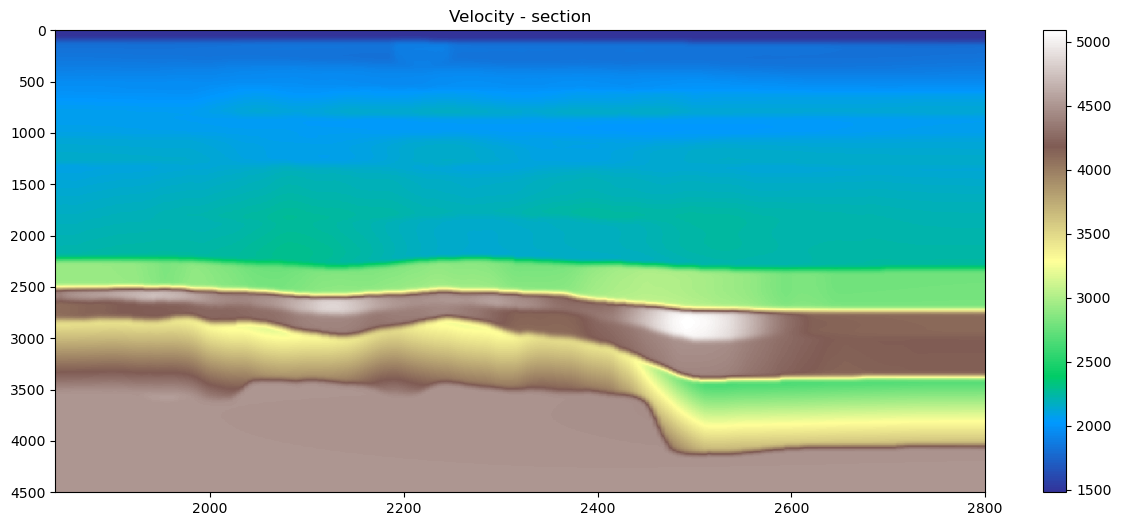

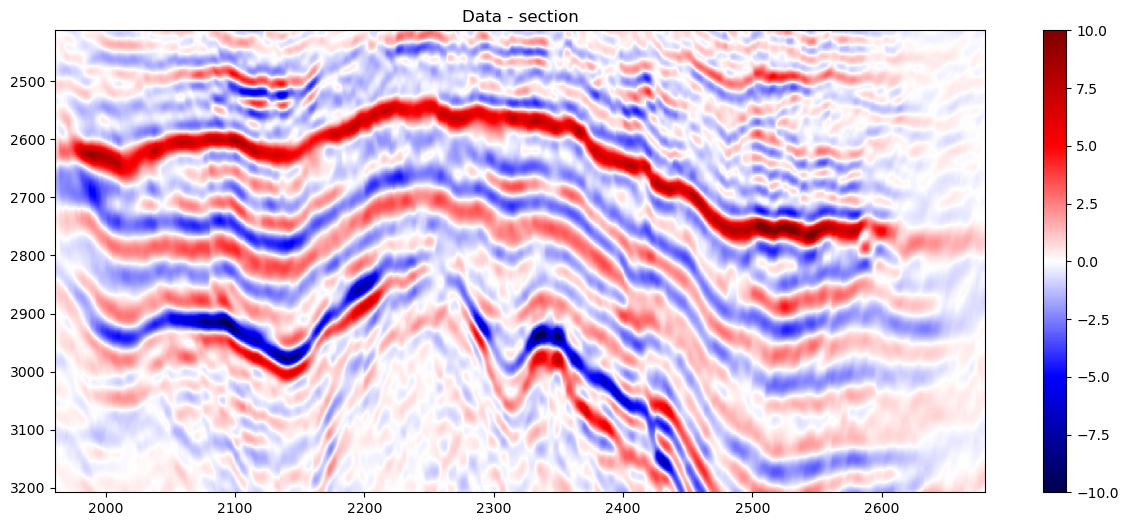

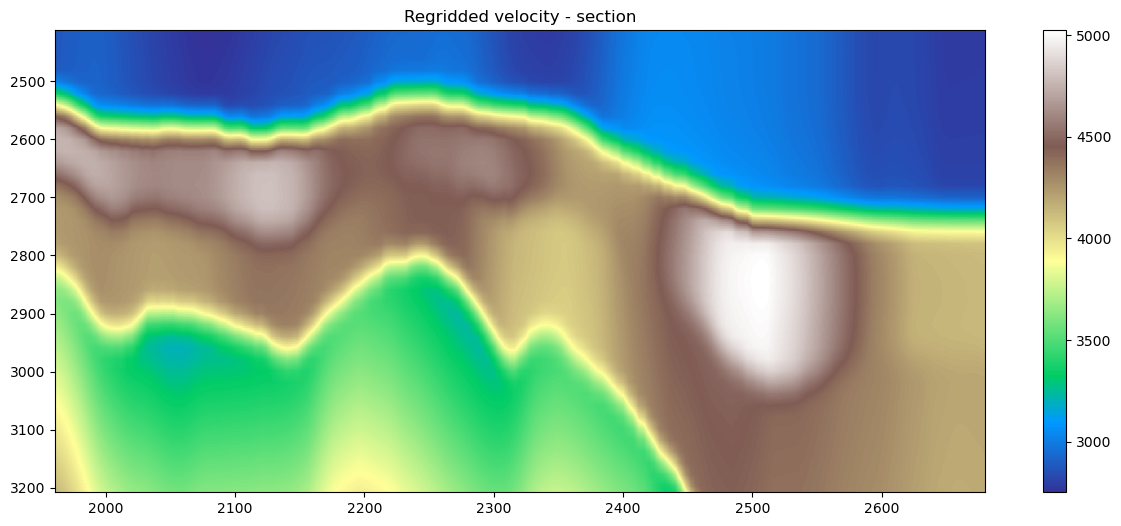

In [5]:
# Display data
plt.figure(figsize=(15, 6))
plt.imshow(v[len(fv.ilines)//2].T, cmap='terrain',
           extent=(fv.xlines[0], fv.xlines[-1], fv.samples[-1], fv.samples[0]))
plt.title('Velocity - section')
plt.colorbar()
plt.axis('tight')

# Display data
plt.figure(figsize=(15, 6))
plt.imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Data - section')
plt.colorbar()
plt.axis('tight');

# Display data
plt.figure(figsize=(15, 6))
plt.imshow(vinterp[nil//2].T, cmap='terrain',
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Regridded velocity - section')
plt.colorbar()
plt.axis('tight');

## Velocity model preparation

We need now to scale this model to its acoustic impedance equivalent. 

This calibration step was performed outside of this notebook using a welllog and this velocity model along a well trajectory. In this example we will simply use a scaling (gradient) and a shift (intercept) from that study.

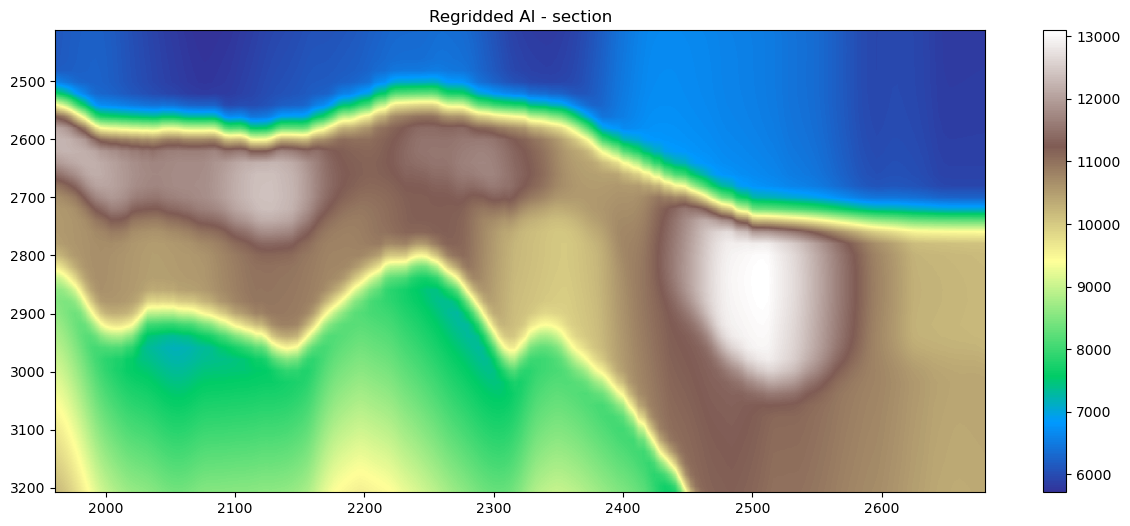

In [6]:
intercept = -3218.0003362662665
gradient = 3.2468122679241023

aiinterp = intercept + gradient*vinterp

# Display data
plt.figure(figsize=(15, 6))
plt.imshow(aiinterp[nil//2].T, cmap='terrain',
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Regridded AI - section')
plt.colorbar()
plt.axis('tight');

## Statistical wavelet estimation

Let's now try to get a quick estimate of the wavelet in our data using a simple statistical wavelet estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a colored inversion.

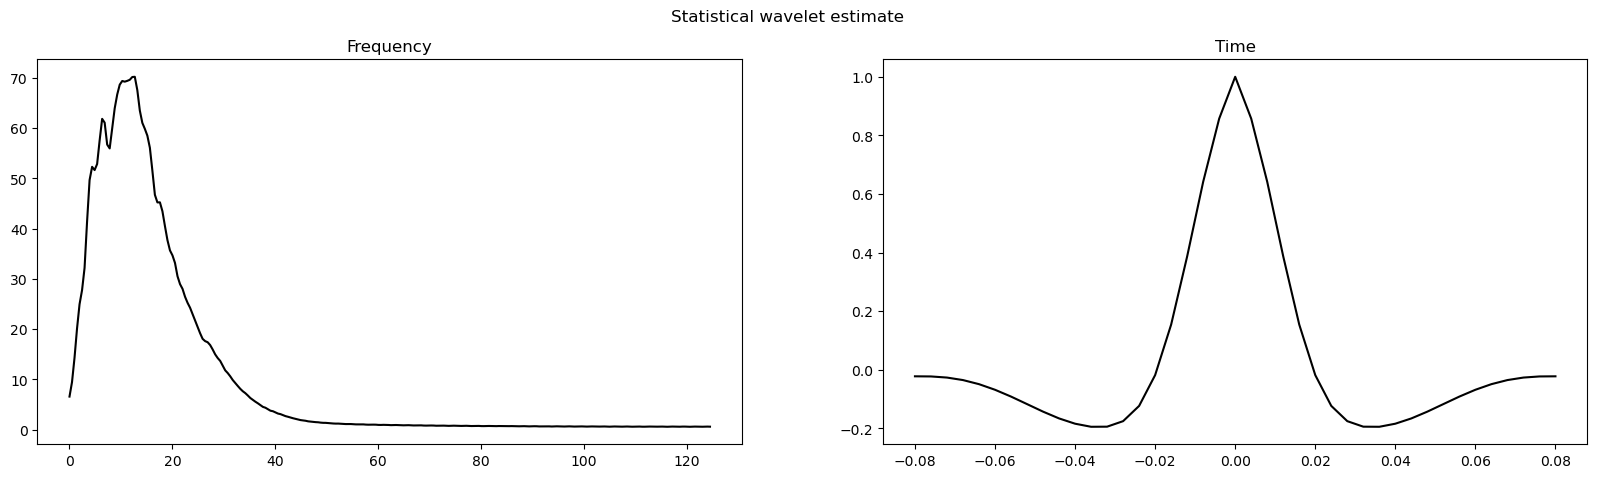

In [7]:
# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

## 3D Inversion

### Inversion with least-squares solver

In [8]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0

# Bring to GPU
d_cp = cp.asarray(d.astype(np.float32))
m0_cp = cp.asarray(m0.astype(np.float32))

/tmp/ipykernel_49006/4092320665.py:5: RuntimeWarning: invalid value encountered in log
  m0 = np.log(aiinterp)


In [9]:
# Inversion
t0 = time.time()
wav_amp = 1e1 # guessed as we have estimated the wavelet statistically
minv, rinv = \
    pylops.avo.poststack.PoststackInversion(d_cp, wav_amp*cp.asarray(wav_est), m0=m0_cp, explicit=False, 
                                            epsR=epsR_sr, **dict(show=True, niter=niter_sr, damp=epsI_sr))
print('Elapsed time (s):', time.time()-t0)

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
minv = np.swapaxes(np.exp(cp.asnumpy(minv)), 0, -1)
rinv = np.swapaxes(cp.asnumpy(rinv), 0, -1)

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 57744000 rows and 57744000 cols
Regs=[<57744000x57744000 Laplacian with dtype=float64>]
epsRs=[0.1]
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 115488000 rows and 57744000 cols
damp = 1.000000e-08	tol = 1.000000e-04	niter = 10
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1       -2.9307e-04         6.0851e+03     6.0851e+03
     2       -8.5392e-04         4.1398e+03     4.1398e+03
     3       -1.6946e-03         3.1343e+03     3.1343e+03
     4       -2.7448e-03         2.5564e+03     2.5564e+03
     5       -4.0805e-03         2.1581e+03     2.1581e+03
     6       -5.6615e-03         1.8677e+03     1.8677e+03
     7       -7.5007e-03         1.6449e+03     1.6449e+03
     8       -9.

### Inversion with Primal-Dual

In [10]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)
aiinterp = np.swapaxes(aiinterp, -1, 0)

m0 = np.log(aiinterp)
m0[np.isnan(m0)] = 0

# Bring to GPU
d_cp = cp.asarray(d.astype(np.float32))
m0_cp = cp.asarray(m0.astype(np.float32))

# Modeling operator
Lop = PoststackLinearModelling(wav_amp*cp.asarray(wav_est), nt0=nt, spatdims=(nxl, nil))
l2 = L2(Op=Lop, b=d_cp.ravel(), niter=niter_in_b, warm=True)

# Regularization
sigma = epsRL1_b
l1 = L21(ndim=3, sigma=sigma)
Dop = Gradient(dims=(nt, nxl, nil), edge=True, dtype=Lop.dtype, kind='forward')

# Steps
L = 12. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1. / np.sqrt(L)
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, m0_cp.ravel(), tau=tau, mu=mu, theta=1., niter=niter_out_b, show=True)
rpd = d.ravel() - cp.asnumpy(Lop * mpd)

mpd = cp.asnumpy(mpd).reshape(aiinterp.shape)
rpd = rpd.reshape(d.shape)

# Swap time axis back to last dimension
aiinterp = np.swapaxes(aiinterp, 0, -1)
d = np.swapaxes(d, 0, -1)
rpd = np.swapaxes(rpd, 0, -1)
mpd = np.swapaxes(np.exp(mpd), 0, -1)

/tmp/ipykernel_49006/3955734599.py:5: RuntimeWarning: invalid value encountered in log
  m0 = np.log(aiinterp)


Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.gradient.Gradient'>
Additional vector (z): None
tau = 0.28867513		mu = 0.2857884
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   0.00000e+00   5.970e+06   5.002e+06   0.000e+00       1.097e+07
     2   1.21004e-02   8.826e+05   4.250e+06   0.000e+00       5.132e+06
     3   3.94548e-02   3.491e+05   4.052e+06   0.000e+00       4.401e+06
     4   9.07969e-02   2.294e+05   3.956e+06   0.000e+00       4.185e+06
     5   1.78780e-01   1.810e+05   3.895e+06   0.000e+00       4.076e+06
     6   3.06559e-01   1.557e+05   3.854e+06   0.000e+00       4.010e+06
     7   4.70581e-01   1.417e+05   3.814e+06   0.000e+00       3.956e+06
     8   6.60859e-01   1.335e+05   3

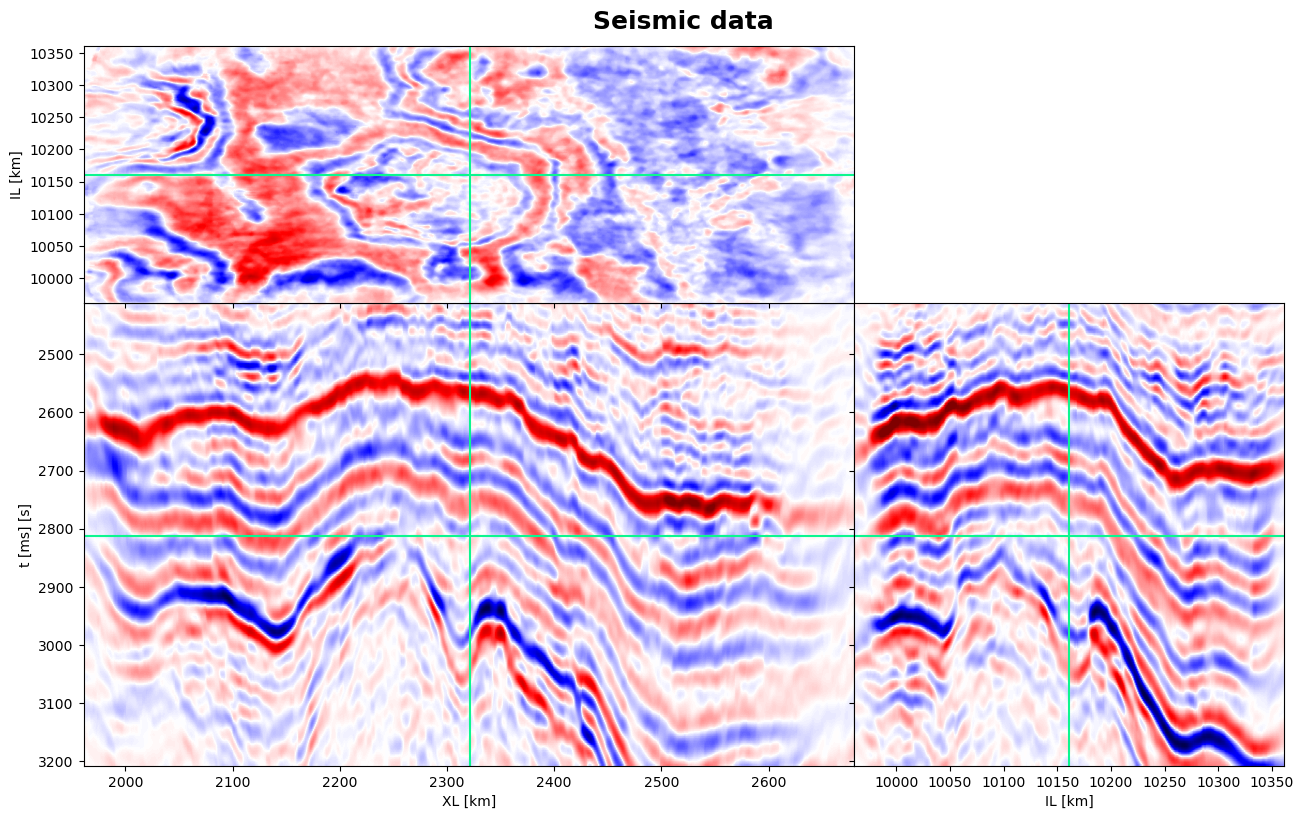

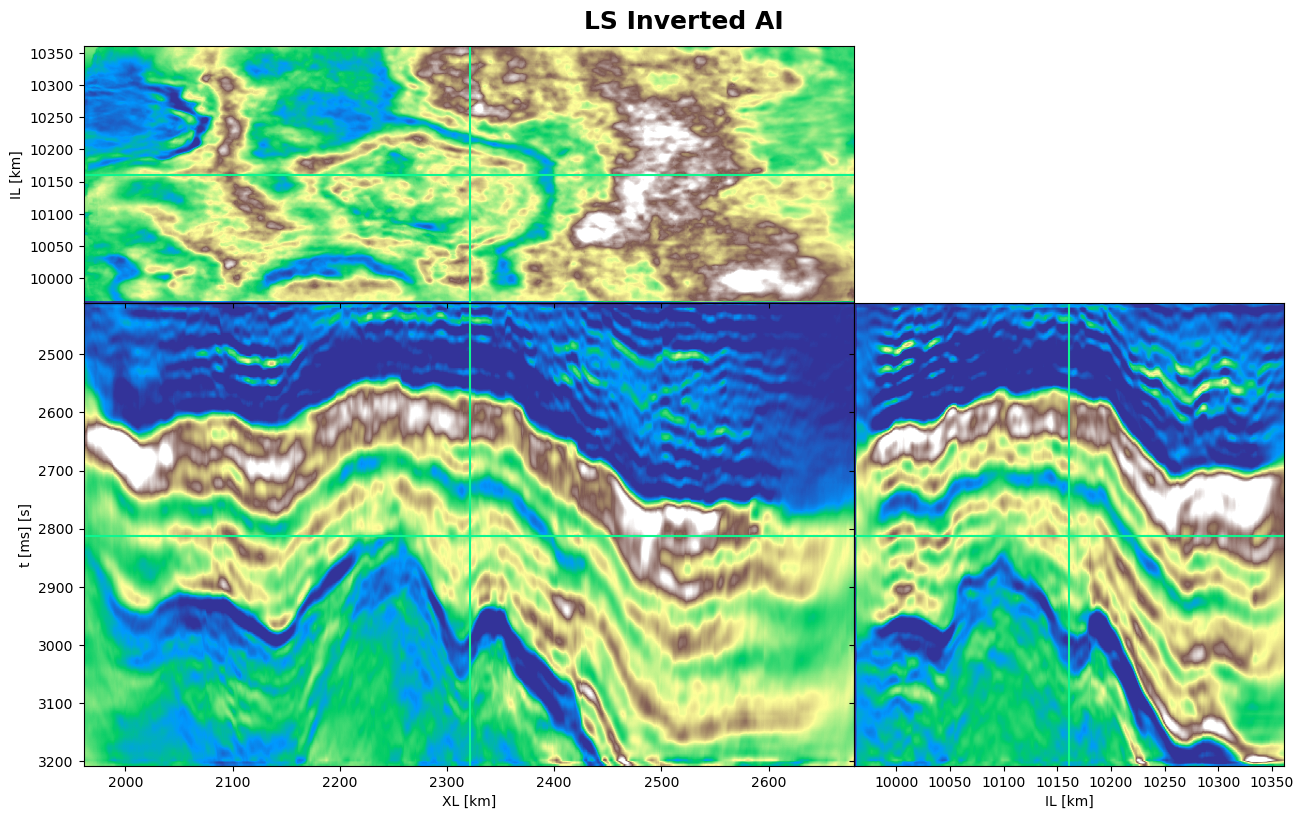

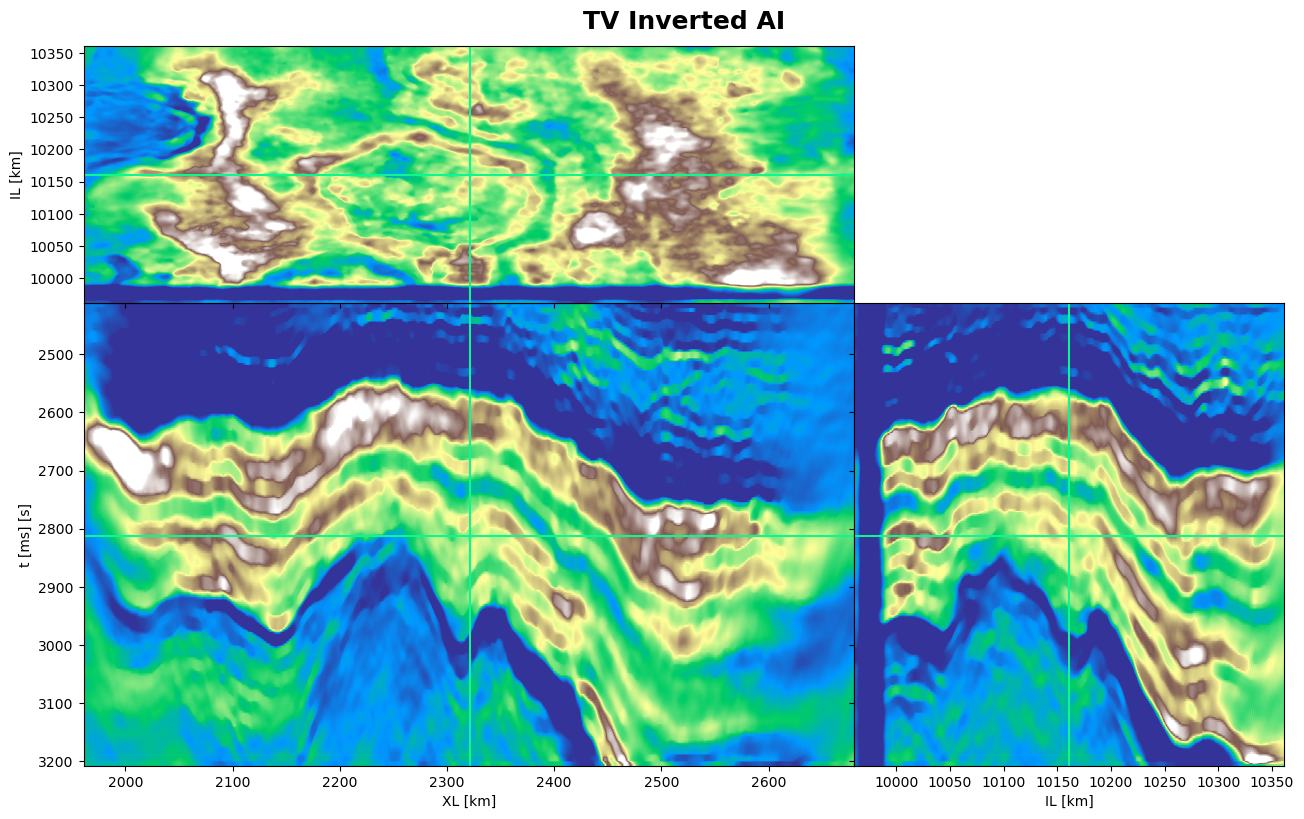

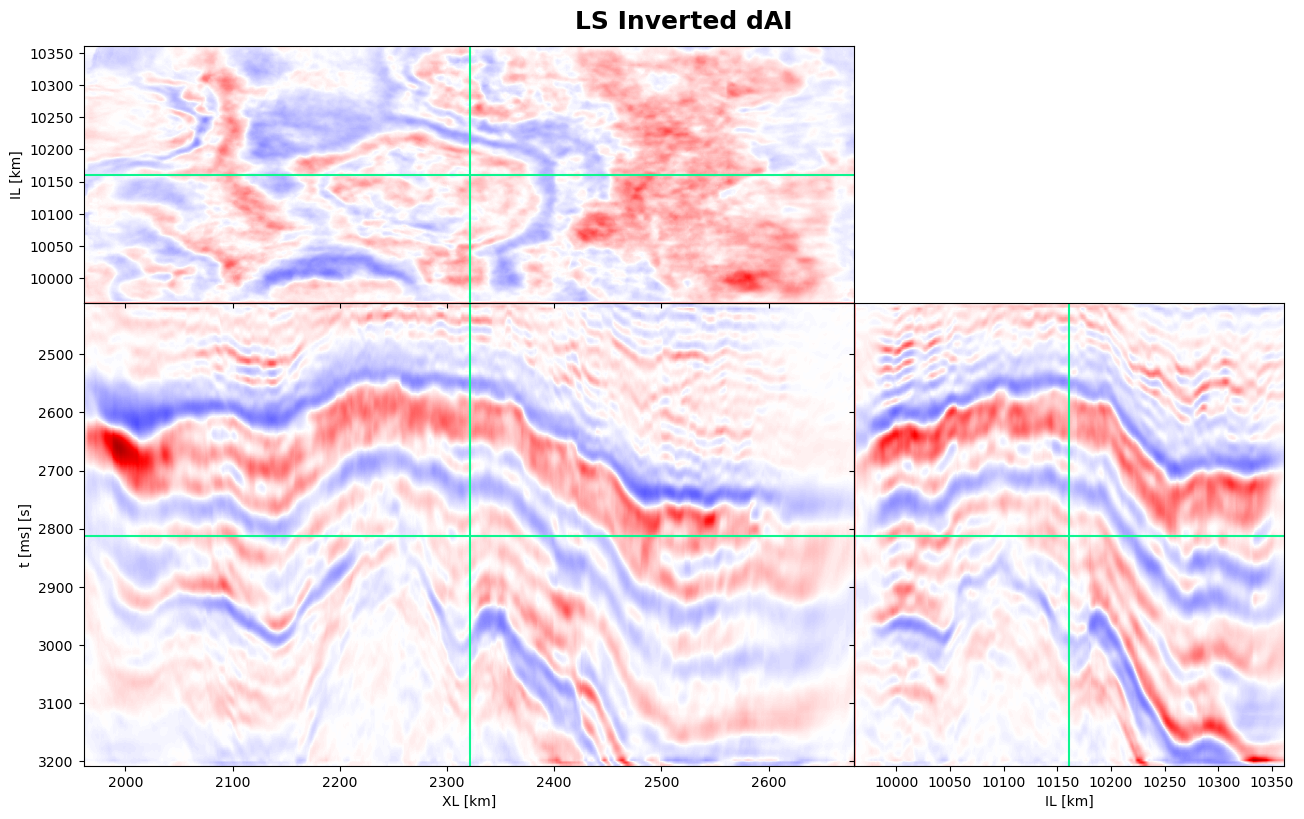

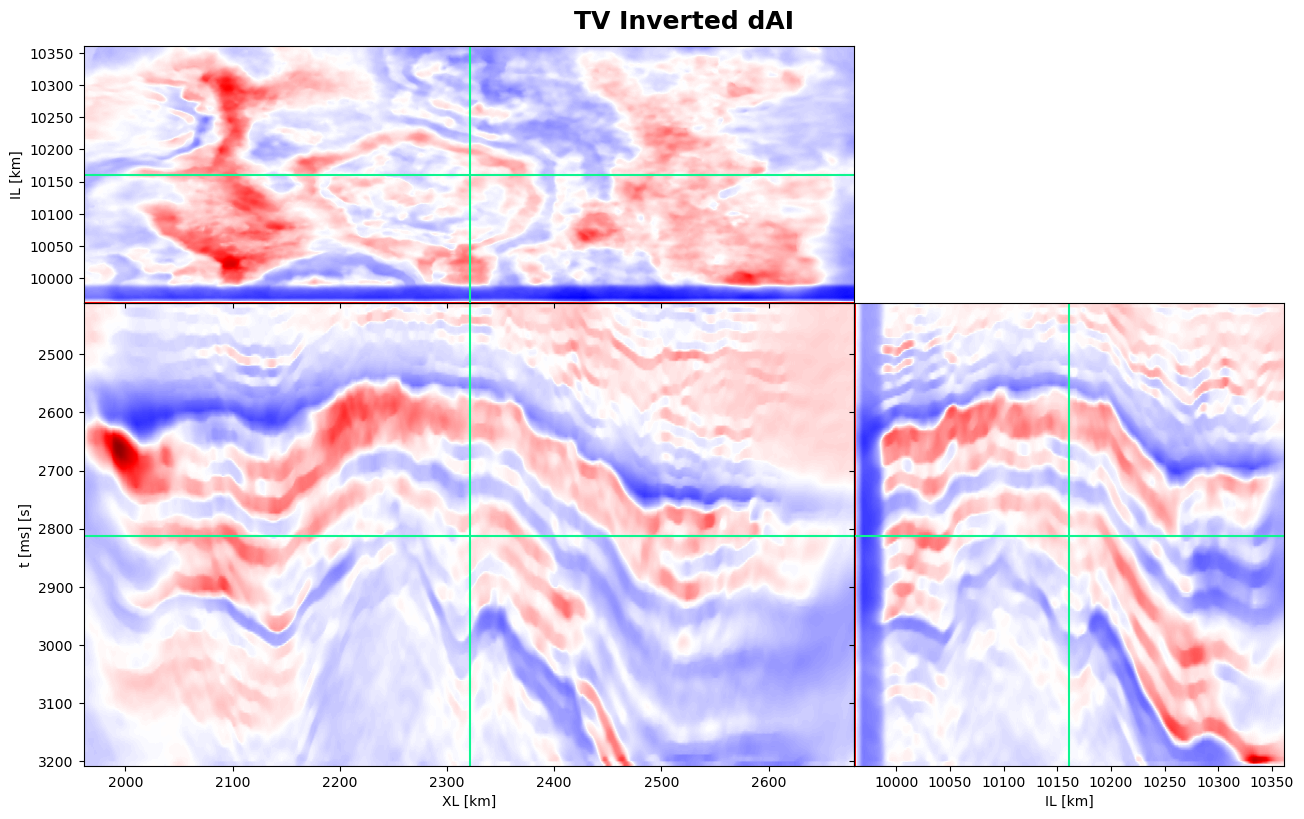

In [11]:
explode_volume(d.transpose(2, 1, 0), cmap='seismic', clipval=(-10, 10),
               tlabel='t [ms]', ylabel='IL', xlabel='XL', 
               ylim=(ilines[0], ilines[-1]), xlim=(xlines[0], xlines[-1]), 
               tlim=(t[0], t[-1]), title='Seismic data', figsize=(15, 9))

explode_volume(minv.transpose(2, 1, 0), cmap='terrain', clipval=(aiinterp[nil//2, nxl//2].min(), 1.5*aiinterp[nil//2, nxl//2].max()),
               tlabel='t [ms]', ylabel='IL', xlabel='XL', 
               ylim=(ilines[0], ilines[-1]), xlim=(xlines[0], xlines[-1]), 
               tlim=(t[0], t[-1]), title='LS Inverted AI', figsize=(15, 9))

explode_volume(mpd.transpose(2, 1, 0), cmap='terrain', clipval=(aiinterp[nil//2, nxl//2].min(), 1.5*aiinterp[nil//2, nxl//2].max()),
               tlabel='t [ms]', ylabel='IL', xlabel='XL', 
               ylim=(ilines[0], ilines[-1]), xlim=(xlines[0], xlines[-1]), 
               tlim=(t[0], t[-1]), title='TV Inverted AI', figsize=(15, 9))

explode_volume(minv.transpose(2, 1, 0) - aiinterp.transpose(2, 1, 0), cmap='seismic', 
               clipval=(-0.7*(minv - aiinterp).max(), 0.7*(minv - aiinterp).max(),),
               tlabel='t [ms]', ylabel='IL', xlabel='XL', 
               ylim=(ilines[0], ilines[-1]), xlim=(xlines[0], xlines[-1]), 
               tlim=(t[0], t[-1]), title='LS Inverted dAI', figsize=(15, 9));

explode_volume(mpd.transpose(2, 1, 0) - aiinterp.transpose(2, 1, 0), cmap='seismic', 
               clipval=(-0.7*(minv - aiinterp).max(), 0.7*(minv - aiinterp).max(),),
               tlabel='t [ms]', ylabel='IL', xlabel='XL', 
               ylim=(ilines[0], ilines[-1]), xlim=(xlines[0], xlines[-1]), 
               tlim=(t[0], t[-1]), title='TV Inverted dAI', figsize=(15, 9));